# Programming exercise 6: Spin coherent states, mean field, and truncated Wigner approximation

Due on Monday, 03.12.2018, 14.15h

### Total: 100 points

## The problem

We will again consider the collective Ising spin-model with a transverse field, as in programming exercise 4 and 5, which is governed by the Hamiltonian
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. We studied this model in detail on the previous exercise sheets using ecaxt diagonalization and numerical integration. Now want to use this system to explore the following useful numerical techniques: We will visualize collective spin states using the Husimi distribution and the mean field and the semi-classical truncated Wigner approximation to simulate its dynamics.

In [2]:
# load modules

 # standard numerics and linear algebra libraries
import numpy as np  
import numpy.linalg as LA
import scipy.linalg as sciLA

# for making plots
import matplotlib.pyplot as plt   

# measure runtimes
import time as time 

# sparse matrix functions
import scipy.sparse as sparse
import scipy.sparse.linalg as sLA

# binomial coefficient
from scipy.special import binom

# for interactive graphics
from ipywidgets import interactive, interact
from ipywidgets import FloatSlider

# avoid typing np.XY all the time
from numpy import (array, pi, cos, sin, ones, size, sqrt, real, mod, append, arange)

# for making Bloch sphere plots
import Bloch
from Bloch import Bloch

# integrator for ordinary differential equations
from scipy.integrate import ode

%matplotlib inline

In [3]:
# some useful definitions

#collective spin operators
def buildSx(N):
    Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
    Splus = sparse.diags(Splusvec,-1)
    return (Splus + Splus.T)/2

def buildSz(N):
    return sparse.diags(np.arange(N+1)-N/2)

def BuildSpinOp(N):
    Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
    Splus = sparse.diags(Splusvec,-1)
    Sz = sparse.diags(np.arange(N+1)-N/2)
    Sx = (Splus + Splus.T)/2
    Sy = (Splus - Splus.T)/(2j)
    return Sx, Sy, Sz

# collective transverse field Ising Hamiltonian
def buildH(N,ome):
    Sx = buildSx(N)
    Sz = buildSz(N)
    return -Sz @ Sz/N - ome*Sx 

# single spin operators
sx = np.array([[0,1],[1,0]])/2
sy = np.array([[0,1j],[-1j,0]])/2
sz = np.array([[1,0],[0,-1]])/2

### Exercise 1 (20 points)

Here you should explore different ways to visualize collective spin states using the Bloch sphere and the Husimi distribution. The Bloch class is a nice tool to visualize spins. I adapted it from the qutip library, a very powerful module for numerical simulation of quantum problems (feel free to install and explore qutip!). To use Bloch() make sure that the file Bloch.py is in the notebook folder or in a directory in your python path.

Use the code below, where a single spin is represented on the Bloch sphere, to familiarize yourself with the Bloch class. We will use it later to visualize the truncated Wigner results.

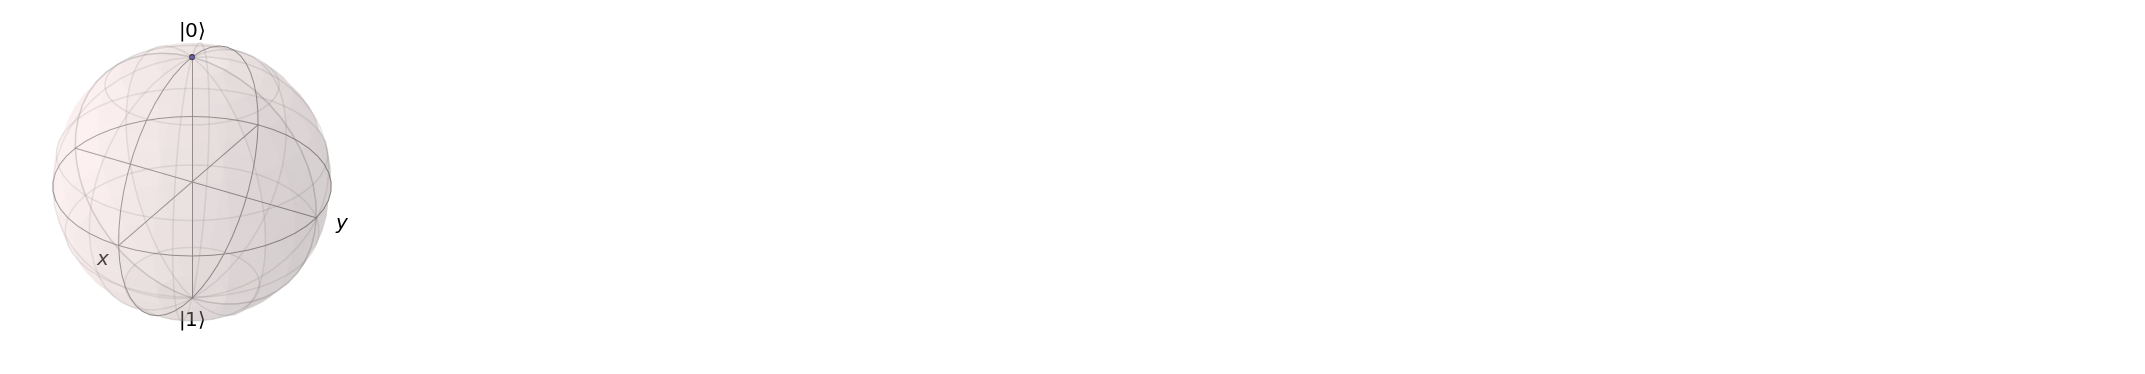

<function __main__.f>

In [4]:
# initially the spin is in the state |0>
ini = np.array([1,0])

# rotate the spin and observe what happens on the Bloch sphere
def f(phi,theta):
    # zero and one state
    zero=np.array([1,0])
    one=np.array([0,1])
    # rotate by an angle phi 
    # (using expm for convenience - You could also calculate the component vector after a general rotation analytically)
    #state = np.cos(theta/2)*zero + np.sin(theta/2)*sciLA.expm(-1j*phi*sx) @ one
    state = np.cos(theta/2)*zero + np.sin(theta/2)*np.exp(1j*phi) * one
    # calculate the spin expectation values
    spinComps = state.conj().T @ [sx, sy, sz] @ state
    # plot a point on the sphere
    b = Bloch()
    b.add_points(2*spinComps)
    b.show()


interact(f, theta=FloatSlider(min=0,max=pi,step=pi/20),phi=FloatSlider(min=0,max=2*pi,step=pi/10))

using the bloch sphere to display any state $|\psi\rangle=\cos(\theta /2)\cdot |0\rangle + e^{i\varphi}\sin(\theta/2)\cdot|1\rangle$

Now consider collective spin vectors. We want to calculate and plot the Husimi distribution, which is the overlap of the state with coherent states. Write a function that returns the coherent spin state
$$
|CSS(\theta,\phi)\rangle = \left[\cos(\theta/2)|0\rangle + e^{i\phi}\sin(\theta/2)|1\rangle \right]^{\otimes N} = \sum_{k=0}^N \cos(\theta/2)^k \sin(\theta/2)^{N-k} e^{ik\phi}\sqrt{\binom N k }|k\rangle
$$
where $|k\rangle$ are the symmetrized states with $k$ zero-spins.
Write a function that returns the Husimi function $H(\theta,\phi)=|\langle CSS(\theta,\phi)|\psi\rangle|^2$ for a grid of angles. Rotate a collective spin about $S_x$ and plot its Husimi distribution for different rotation angles. You can again use expm. How does the width of the distribution depend on N?

Close to the poles ($\theta=0,\pi$), the distribution in $\theta$ and $\phi$ gets distorted a lot compared to the ditribution on the Bloch sphere. Below are some other examples of how to visualize the collective spin. As an example, we evolve the state under the collective Ising Hamiltonian to see the dynamics of the distribution. Try different atom numbers and $\Omega$s. What happens at $\Omega=0.5$?

In [5]:
# This will only work if you define a function CSS(N,th,ph)

def symState(N,k):
    return np.identity(N+1)[k]

def CSS(N,th,ph):
    state=np.zeros(N+1,dtype=complex)
    for k in range(N+1):
        state+=cos(th/2)**k*sin(th/2)**(N-k)*np.exp(1j*k*ph)*sqrt(binom(N,k))*symState(N,k)
    return state
# Make a Husimi plot in z and phi
def Husimi_z_th(N,psi,nz,nph):
    z = np.linspace(-1,1,nz+1,endpoint=True)
    th = np.arccos(z)
    ph = np.linspace(0,2*pi,nph,endpoint=False)
    H = np.zeros((len(th),len(ph)))
    for ix in range(len(th)):
        for iy in range(len(ph)):
            H[ix,iy] = np.abs(psi.conj().T @ CSS(N,th[ix],ph[iy]))**2
    return z, ph, H

# Make a Husimi plot in z and y looking from +x direction
def Husimi_front(N,psi,nz,ny):
    z = np.linspace(-1,1,nz,endpoint=True)
    y = np.linspace(-1,1,ny,endpoint=True)
    H = np.zeros((len(z),len(y)))
    mask = np.zeros_like(H, dtype=bool) # make are outside of the circle white
    eps = 10e-10
    for iz in range(len(z)):
        for iy in range(len(y)):
            if z[iz]**2+y[iy]**2 > 1: # outside allowed region
                H[iz,iy] = 0
                mask[iz,iy] = True
            else:
                th = np.arccos(z[iz])
                if th==0 or th==pi:
                    ph = 0
                else:
                    ph = np.arcsin(y[iy]/sin(th)) # corresponds to positive x
                H[iz,iy] = np.abs(psi.conj().T @ CSS(N,th,ph))**2
                mask[iz,iy] = False
            H = np.ma.array(H, mask=mask)
    return z, y, H

# Make a Husimi plot in z and y looking from -x direction
def Husimi_back(N,psi,nz,ny):
    z = np.linspace(-1,1,nz,endpoint=True)
    y = np.linspace(-1,1,ny,endpoint=True)
    H = np.zeros((len(z),len(y)))
    mask = np.zeros_like(H, dtype=bool)
    for iz in range(len(z)):
        for iy in range(len(y)):
            if z[iz]**2+y[iy]**2 > 1:
                H[iz,iy] = 0
                mask[iz,iy] = True
            else:
                th = np.arccos(z[iz])
                if th==0 or th==pi:
                    ph = 0
                else:
                    ph = pi - np.arcsin(y[iy]/sin(th)) # corresponds to negative x
                H[iz,iy] = np.abs(psi.conj().T @ CSS(N,th,ph))**2
                mask[iz,iy] = False
            H = np.ma.array(H, mask=mask)
    return z, y, H

# Make a Husimi plot in x and y looking from +z direction
def Husimi_top(N,psi,nx,ny):
    x = np.linspace(-1,1,nx,endpoint=True)
    y = np.linspace(-1,1,ny,endpoint=True)
    H = np.zeros((len(x),len(y)))
    mask = np.zeros_like(H, dtype=bool)
    for ix in range(len(x)):
        for iy in range(len(y)):
            if x[ix]**2+y[iy]**2 > 1:
                H[ix,iy] = 0
                mask[ix,iy] = True
            else:
                z = sqrt(1-x[ix]**2-y[iy]**2)
                th = np.arccos(z)
                # avoid dividing by 0; Gets a bit tricky.
                if x[ix]==0:
                    if y[iy]>=0:
                        ph = pi/2
                    else:
                        ph = 3*pi/2
                elif x[ix]>0:
                    ph = np.arctan(y[iy]/x[ix])
                else:
                    ph = pi + np.arctan(y[iy]/x[ix])
                H[ix,iy] = np.abs(psi.conj().T @ CSS(N,th,ph))**2
                mask[ix,iy] = False
            H = np.ma.array(H, mask=mask)
    return x, y, H


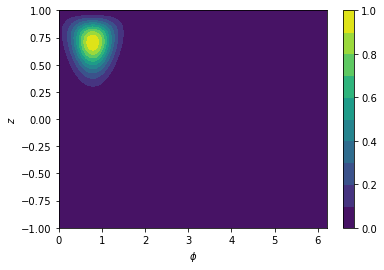

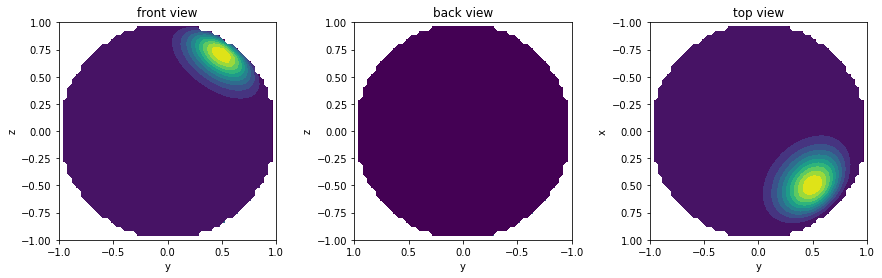

In [5]:
# visualize a coherent spin state

N=40
psi = CSS(N,1*pi/4,1*pi/4)
HscaleMax = 1 # clipping value for colorscale. Will later be uselful.

# plot distribution in z and phi
zvec, phvec, Hdistr = Husimi_z_th(N,psi,40,80)
plt.contourf(phvec, zvec, Hdistr, 10)
plt.colorbar()
plt.xlabel('$\phi$')
plt.ylabel('$z$')
plt.show()

# plot different projections of the sphere
# front
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
zvec, yvec, Hdistr = Husimi_front(N,psi,50,50)
plt.imshow(Hdistr,extent=[-1, 1, -1, 1],aspect=1) # only for setting option
plt.contourf(zvec, yvec, Hdistr, 10, vmax=HscaleMax) # data in plot gets overwritten
plt.title("front view")
plt.xlabel('y')
plt.ylabel('z')
# back
plt.subplot(1,3,2)
zvec, yvec, Hdistr = Husimi_back(N,psi,50,50)
plt.imshow(Hdistr,extent=[1, -1, -1, 1],aspect=1)
plt.contourf(zvec, yvec, Hdistr, 10, vmax=HscaleMax)
plt.title("back view")
plt.xlabel('y')
plt.ylabel('z')
# top
plt.subplot(1,3,3)
xvec, yvec, Hdistr = Husimi_top(N,psi,50,50)
plt.imshow(Hdistr,extent=[-1, 1, 1, -1],aspect=1)
plt.contourf(xvec, yvec, Hdistr, 10, vmax=HscaleMax)
plt.title("top view")
plt.xlabel('y')
plt.ylabel('x')
plt.show()

In [6]:
# function for plotting Bloch sphere projections taking pre-calculated Husimi disributions as input 
# assuming the same grid in both directions
def plot_H_all(Hfront,Hback,Htop,grid,HscaleMax=1):
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1) # front
    plt.imshow(Hfront,extent=[-1, 1, -1, 1],aspect=1)
    plt.contourf(grid, grid, Hfront, 10, vmax=HscaleMax)
    plt.title("front view")
    plt.xlabel('y')
    plt.ylabel('z')
    plt.subplot(1,3,2) # back
    plt.imshow(Hback,extent=[1, -1, -1, 1],aspect=1)
    plt.contourf(grid, grid, Hback, 10, vmax=HscaleMax)
    plt.title("back view")
    plt.xlabel('y')
    plt.ylabel('z')
    plt.subplot(1,3,3) # top
    plt.imshow(Htop,extent=[-1, 1, 1, -1],aspect=1)
    plt.contourf(grid, grid, Htop, 10, vmax=HscaleMax)
    plt.title("top view")
    plt.xlabel('y')
    plt.ylabel('x')
    plt.show()

In [7]:
# calculate the full quantum dynamics by exact diagonalization
N = 100
ome = 0.4
HscaleMax = 0.5 # if set to 1 distribution is hardly visible for late times...
Hmat = buildH(N,ome)
ini = np.eye(1,N+1,N)[0]

# diagonalize
evals, evecs = LA.eigh(Hmat.toarray())

# calculate projections on eigenstates
iniProj = evecs.conj().T @ ini

# precalculate Husimi distributions
t1 = 10
dt = 0.2
tsteps = int(t1/dt)
tvec = np.linspace(0,dt*tsteps,tsteps+1)
ngrid = 40
grid = np.linspace(-1,1,ngrid,endpoint=True)

HfrontAll = np.ma.array(np.zeros((ngrid,ngrid,len(tvec))))
HbackAll =  np.ma.array(np.zeros((ngrid,ngrid,len(tvec))))
HtopAll =  np.ma.array(np.zeros((ngrid,ngrid,len(tvec))))

for it in range(len(tvec)):
    print(it,end=' ')
    Psit = evecs @ (np.exp(-1j*evals*tvec[it])*iniProj)
    zvec, yvec, HfrontAll[:,:,it] = Husimi_front(N,Psit,ngrid,ngrid)
    zvec, yvec, HbackAll[:,:,it] = Husimi_back(N,Psit,ngrid,ngrid)
    zvec, yvec, HtopAll[:,:,it] = Husimi_top(N,Psit,ngrid,ngrid)    

# interactive plotting
def f(it):    
    it = int(it)
    plot_H_all(HfrontAll[:,:,it],HbackAll[:,:,it],HtopAll[:,:,it],grid,HscaleMax)
    
interact(f, it=FloatSlider(min=0,max=len(tvec)-1,step=1))

0 1 2 3 

KeyboardInterrupt: 

### Exercise 2 (20 points)

Now we want to understand this dynamics better by examining the mean-field dynamics.
The mean-field energy functional reads
$$
E_{MF}/(N/2) = -z^2/2 - \Omega \sqrt{1-z^2}\cos(\phi) 
$$
which leads to the mean field equations of motion
$$
\dot z = -\Omega \sqrt{1-z^2}\sin(\phi) \\
\dot \phi = -z + \Omega \frac{z}{\sqrt{1-z^2}}\cos(\phi) 
$$
Plot mean field energy as a contour plot in $z$ and $\phi$ for different $\Omega$. The mean field trajectories follow the iso-energy lines. Where are stable and unstable fixpoints? Where is the sparatrix between trajectories circling a stable fixpoint and the ones rotating around the whole sphere. What happens at $\Omega=0.5$?

The answers to these questions will become more obvious when you solve the mean-field equations. 

Optional: Solve the mean field equations in $z$ and $\phi$ numerically. (Next we will solve them in the spin components, which is more convenient for truncated Wigner simualtions.)

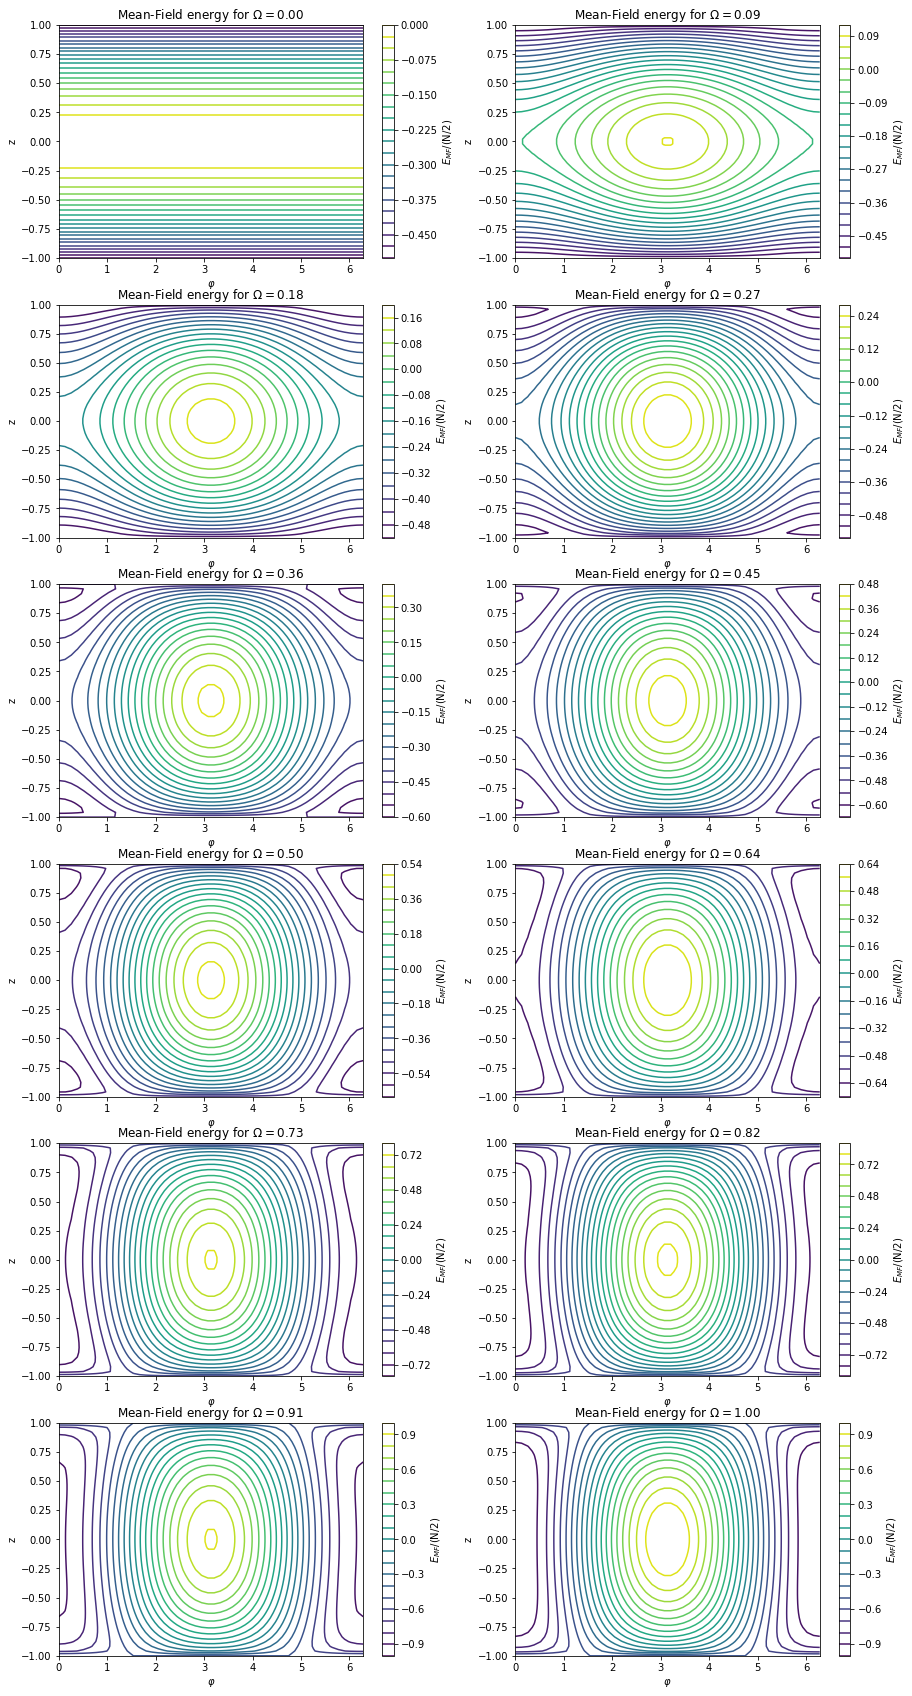

In [9]:
def Emf(ph,z,om):
    return -z**2/2-om*sqrt(1-z**2)*cos(ph)
z=np.linspace(-1,1,50)
ph=np.linspace(0,2*pi,50)
phM,zM=np.meshgrid(ph,z)
fig=plt.figure(figsize=(15,30))
omSpace=np.linspace(0,1,12)
omSpace[int(len(omSpace)/2)]=.5 #ensure that we have Omega=.5 once
for i in range(len(omSpace)):
    om=omSpace[i]
    fig.add_subplot(int(len(omSpace)/2),2,i+1)
    plt.title('Mean-Field energy for $\Omega=%.2f$'%om)
    plt.xlabel(r'$\varphi$')
    plt.ylabel('z')
    plt.contour(ph,z,Emf(phM,zM,om),20)
    plt.colorbar().set_label('$E_{MF}$/(N/2)')


In the center of each iso-energy line there is a fixpoint. The one in the middle of each plot is an unstable fixpoint because it's a point of high energy. The ones on the side are all stable fixpoints because the energy gets lower.

### Exercise 3 (30 points)

In the spin components, the mean-field equations read ($x=S_x/(N/2)$ etc.)
$$
\dot x = yz \\
\dot y = -xz + \Omega z \\
\dot z = -\Omega y
$$
Solve these equation using your integrator of choice. (I used scipy's integrate.ode again with the same options as on programming exercise 5)

Plot the trajectories for different initial conditions and different $\Omega$. You can plot them on the Bloch sphere adapting the example above or plotting the projection on xz, yz, or xy plane. Make sure that the outcome matches your expectations from the mean field energy functional.

It is instructive to see what changes for the trajectory starting at the north pole (x,y,z) = (0,0,1) when $\Omega$ is increased from below 0.5 to above.

In [66]:
def f(t,vec,Om):
    x,y,z=vec
    return [y*z,-x*z+Om*z,-Om*y],
def fieldEq(Om):
    r = ode(f).set_integrator('zvode', method='adams', with_jacobian=False)
    r.set_initial_value([0,0,1], 0).set_f_params(Om)
    points=[]
    dt=.01
    while r.successful() and r.t < 100:
        points.append(r.integrate(r.t+dt))
        if LA.norm(points[-1]-array([0,0,1]))<.01 and r.t>2:
            break
    data=np.transpose(points).real
    fig=plt.figure(figsize=(20,5))
    for i in range(3):
        fig.add_subplot(1,3,i+1)
        plt.plot(data[i%3],data[(i+1)%3])
        plt.xlabel('xyz'[i%3])
        plt.ylabel('xyz'[(i+1)%3])
    fig.suptitle('$\Omega=%.2f$'%Om)
    plt.show()

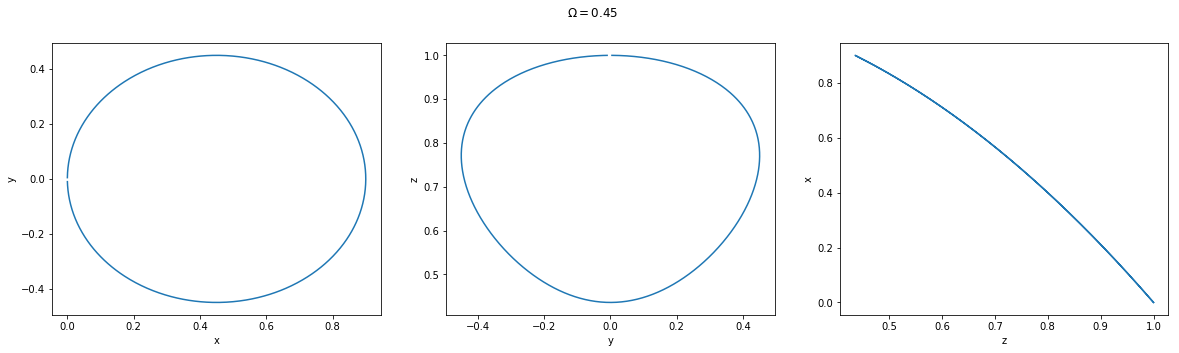

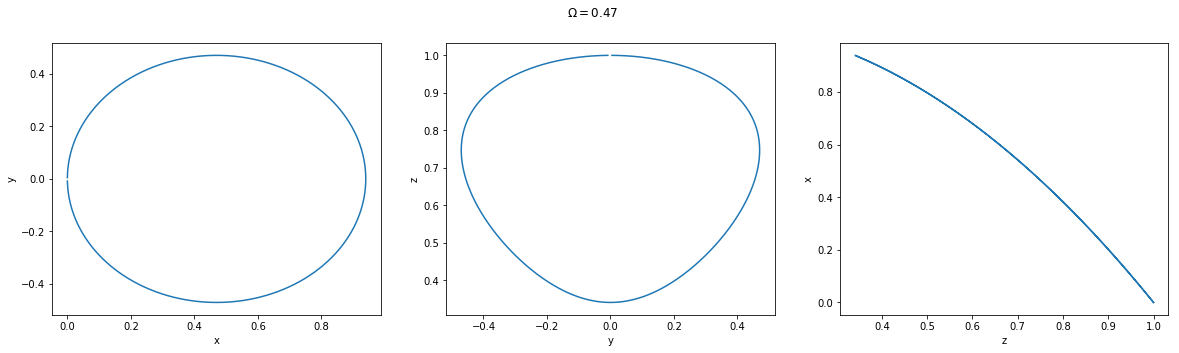

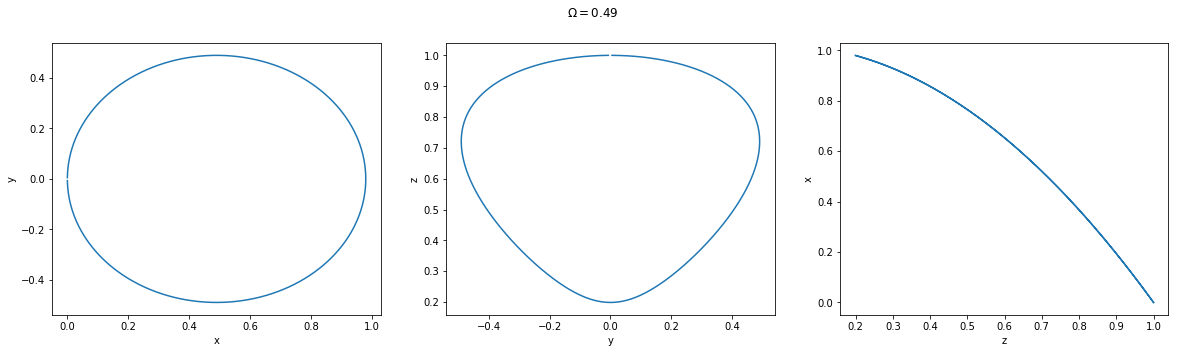

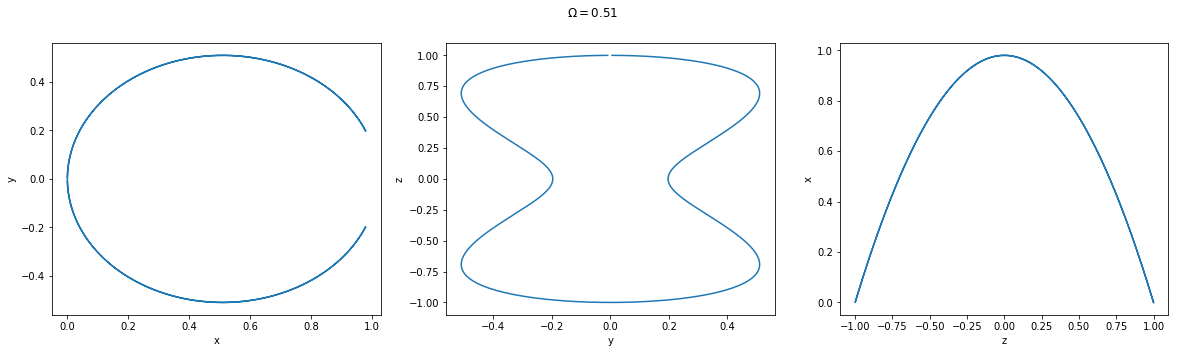

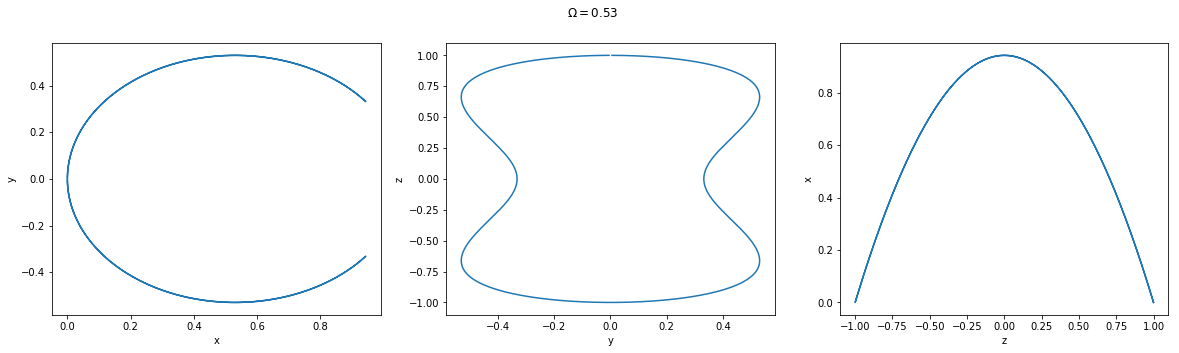

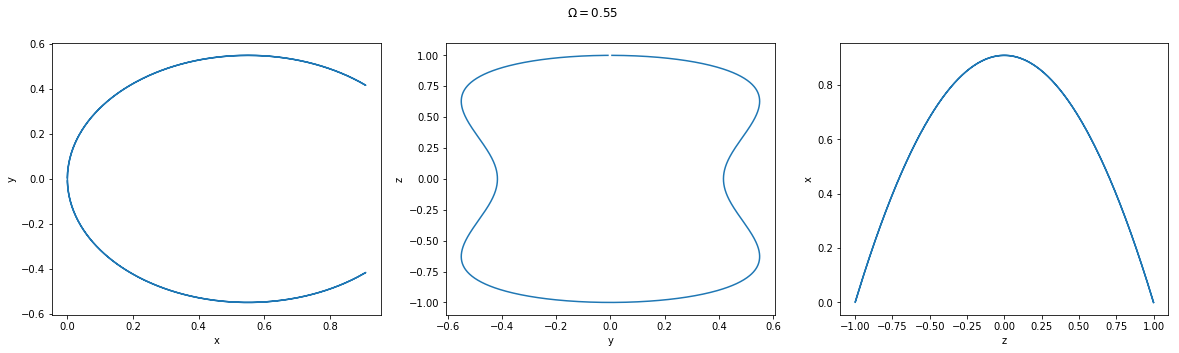

In [67]:
for Om in np.linspace(.45,.55,6):
    fieldEq(Om)

We can see that as $\Omega$ gets higher than $0.5$ the curv in the xy-plot doesn't close anymore.

### Exercise 4 (30 points)

Now we are ready to implement the truncated Wigner simulation. Calculate the classical trajectories of a sample of points that is Gaussian distributed around 0 in x and y (with $\sigma=1/\sqrt{N}$) and has the value z=1 initially. This corresponds to an initial coherent spin state with $\theta=\phi=0$

Plot the TWA outcome on the Bloch sphere.

Compare the outcome of the expectation value of the spin components and their variances to the exact solution. Plot them in the same axes as a function of time. For the expectation values of the spin components, also plot the mean-field solution, i.e. the mean field trajectory starting at the noth pole of the sphere.

Use $N=20$ and $100$ and a number of sampled trajectories of $100$ and $1000$ to see how this influences the performance of TWA. Interpret your results.

The code below gives you some guidance on how to proceed.

In [84]:
# calculate full quantum case for comparing to TWA
N = 100
ome = 0.4
Hmat = buildH(N,ome)
ini = CSS(N,0,0)

# diagonalize
evals, evecs = LA.eigh(Hmat.toarray())

# calculate projections on eigenstates
iniProj = evecs.conj().T @ ini

# calculate observables
t1 = 10
dt = 0.1
tsteps = int(t1/dt)
tvec = np.linspace(0,dt*tsteps,tsteps+1)

obsExact = 1j*np.zeros((len(tvec),6))

Sx, Sy, Sz = BuildSpinOp(N)

for it in range(len(tvec)):
    Psit = evecs @ (np.exp(-1j*evals*tvec[it])*iniProj)
    obsExact[it,0:3] = [Psit.conj().T @ Sx @ Psit, 
                        Psit.conj().T @ Sy @ Psit, 
                        Psit.conj().T @ Sz @ Psit]
    obsExact[it,0:3] = obsExact[it,0:3]/(N/2)
    obsExact[it,3:6] = [Psit.conj().T @ Sx @ Sx @ Psit, 
                        Psit.conj().T @ Sy @ Sy @ Psit, 
                        Psit.conj().T @ Sz @ Sz @ Psit]
    obsExact[it,3:6] = obsExact[it,3:6]/(N/2)**2 - obsExact[it,0:3]**2


In [ ]:
# truncated Wigner: sample the initial condition from Gaussian distribution
# to run this you need a function get_trajectory(ini, tvec, ome) 
# which solves the mean field equations and returns a tranjectory (Sx(t),Sy(t),Sz(t))
# make sure you understand what the following code does...!
nsamples = 100
xy_ini = np.random.normal(0,1/sqrt(N),(nsamples,2)) # Gaussian random numbers for x and y
ini_list = np.transpose([xy_ini[:,0],xy_ini[:,1],np.full(nsamples,1)]) # add constant 1 for z

all_trajectories = np.zeros((len(ini_list),len(tvec),3))

# loop over initial conditions
t1=time.time()
for i in range(len(ini_list)):
    all_trajectories[i] = get_trajectory(ini_list[i], tvec, ome)
t2=time.time()
print(t2-t1)

In [ ]:
# interactive plot of the distribution on the Bloch sphere
def plotTWA_distr_bloch(it):
    it = int(it)
    b = Bloch()
    b.add_points(np.transpose(all_trajectories[:,it]))
    b.show()

interact(plotTWA_distr_bloch, it=FloatSlider(min=0,max=len(tvec)-1,step=1))

In [ ]:
# calculate observables and compare to exact result
# calculate means and variances in all 3 directions
obsTWA = np.zeros((len(tvec),6))
### your code here ###

# plotting
plt.plot(tvec,obsTWA[:,0],'r')
plt.plot(tvec,obsTWA[:,1],'g')
plt.plot(tvec,obsTWA[:,2],'b')
plt.plot(tvec,obsExact[:,0],'r--')
plt.plot(tvec,obsExact[:,1],'g--')
plt.plot(tvec,obsExact[:,2],'b--')
plt.xlabel('t')
plt.ylabel('observables')
plt.legend(['$S_x/(N/2)$','$S_y/(N/2)$','$S_z/(N/2)$'])
plt.show()

plt.plot(tvec,obsTWA[:,3],'r')
plt.plot(tvec,obsTWA[:,4],'g')
plt.plot(tvec,obsTWA[:,5],'b')
plt.plot(tvec,obsExact[:,3],'r--')
plt.plot(tvec,obsExact[:,4],'g--')
plt.plot(tvec,obsExact[:,5],'b--')
plt.xlabel('t')
plt.ylabel('observables')
plt.legend(['$var(S_x/(N/2))$','$var(S_y/(N/2))$','$var(S_z/(N/2))$'])
plt.show()